### Triple Barrier Methods

Here, we introduce an alternative labeling technique that has not been seen in academic papers. If the readers are investment experts, I think they will agree that this method is more reasonable. Author Lopez de Prado calls this the Triple Barrier because observations are labeled according to which of the three barriers is reached first. First, set up two horizontal barriers and one vertical barrier. The two horizontal barriers are defined by take profit and stop loss limits, which are dynamic functions of the estimated volatility. The third barrier is defined by the number of bars passed after taking the position (expiration limit). 

If the upper barrier is reached first, the observation value is labeled as 1, and if the lower barrier is reached first, the observation value is labeled as -1. If you reach the vertical barrier first, you have two choices. It is either set to the profit or loss sign or set to 0. Since it is a problem of realizing profit or loss within a limit, the author prefers the former, but it is good to check whether labeling for 0 works better for each problem.

In [5]:
# Setup path to import FinancialMachineLearning modules
import sys
from pathlib import Path

# Add the MLFinance root directory to Python path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # Go up from Notes/Week05Labeling to MLFinance
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"✓ Added {project_root} to Python path")

✓ Added /mnt/ssd_backup/equity-ml-ldp/MLFinance to Python path


In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

start_date = '2015-03-31'
end_date = '2025-09-25'
ticker = 'AAPL'

# Download data with auto_adjust=True (default) - all prices are adjusted
# This is recommended for financial ML as all OHLC prices are consistent
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date,
    multi_level_index=False,
    auto_adjust=True  # Recommended: returns adjusted OHLC prices
)

print(f"✓ Data loaded: {data.shape}")
print(f"✓ Columns: {data.columns.tolist()}")
data.head()

[*********************100%***********************]  1 of 1 completed

✓ Data loaded: (2638, 5)
✓ Columns: ['Close', 'High', 'Low', 'Open', 'Volume']


,Close,High,Low,Open,Volume
Date,,,,,
2015-03-31,27.720808,28.179739,27.705213,28.090626,168362400
2015-04-01,27.680714,27.874535,27.424514,27.807700,162485600
2015-04-02,27.919085,27.972552,27.667341,27.854477,128880400
2015-04-06,28.371336,28.406982,27.698534,27.729723,148776000
2015-04-07,28.072803,28.542873,28.066120,28.435938,140049200


In [7]:
from FinancialMachineLearning.labeling.labeling import *
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'],  # Use 'Close' (already adjusted when auto_adjust=True)
    num_days = 7 # expiration limit
)
print(f"\n✓ Vertical barriers created: {len(vertical_barrier)} timestamps")

vertical_barrier.head()


✓ Vertical barriers created: 2633 timestamps


Date
2015-03-31   2015-04-07
2015-04-01   2015-04-08
2015-04-02   2015-04-09
2015-04-06   2015-04-13
2015-04-07   2015-04-14
Name: Date, dtype: datetime64[ns]

The output of this function is a `pandas.DataFrame` containing a timestamp, which is the time each barrier was reached. As can be seen from the previous explanation, this technique takes into account the possibility that each of the three barriers will be deactivated. Let's express the barrier setting as three values: `[pt, sl, t1]`. Here, 0 means the barrier is inactive and 1 means it is active. The eight settings are as follows.

**Three useful settings**

| profit taking | stopping loss | vertical barrier | description                                                                                                                        |
|:-------------:|:-------------:|:----------------:|:-----------------------------------------------------------------------------------------------------------------------------------|
|       1 |       1 |        1 | As a standard setting, escape conditions for three barriers are defined. You want to realize profits, but there are restrictions on the maximum loss you can tolerate and your holding period.                                                            |
|       0 |       1 |        1 | There are only stop losses and vertical barriers. If you don't have a stop loss, you want to break out of the barrier after a few bars.                                                                              |
|1|1|0| We aim to realize profits as long as we do not stop at a loss. This is unrealistic as it involves holding a position for however long it takes.                                                                  |

**3 more unrealistic settings**
| profit taking | stopping loss | vertical barrier | description                                                                                                                        |
|:-------------:|:-------------:|:----------------:|:-----------------------------------------------------------------------------------------------------------------------------------|
|       0 |       0 |        1 | It is the same as the fixed period method. It can still be useful when applied to volume, value, or information driven bars or when updating multiple forecasts within a fixed period.                                                            |
|       1 |       0 |        1 | Hold positions until they are profitable or until the maximum holding period expires. Intermediate unrealized losses are not taken into account.                                                                              |
|       1 |       0 |0         | Hold the position until you make a profit. This means that you may be stuck in a loss position for several years.                                                                       |

**Two illogical settings**

| profit taking | stopping loss | vertical barrier | description                             |
|:-------------:|:-------------:|:----------------:|:----------------------------------------|
|       0 |       1 |        0 | As this is a setting without a target, it is simply held until the stop loss is processed.        |
|       0 |       0 |        0 | There is no barrier. The position is fixed forever and no label is generated. |


### Learning side and size

In this section, we discuss how to label data so that machine learning algorithms can learn the direction and size of bets. Usually, when there is no base model that sets the sign of the position (buy or sell), one is interested in finding out the direction of the bet. In this situation, there is no way to distinguish between the profit taking barrier (upper bound) and the stopping loss barrier (lower bound) because there is no knowledge of the direction. Finding the direction implies either that there is no horizontal barrier or that the horizontal barrier is symmetrical.

In [8]:
from FinancialMachineLearning.features.volatility import daily_volatility

volatility = daily_volatility(data['Close'], lookback = 60)  # Use 'Close'

print(f"✓ Volatility calculated (60-day lookback)")
print(f"  Mean volatility: {volatility.mean():.4f} ({volatility.mean()*100:.2f}%)")
print(f"  Std volatility:  {volatility.std():.4f}")

✓ Volatility calculated (60-day lookback)
  Mean volatility: 0.0223 (2.23%)
  Std volatility:  0.0071


In [9]:
triple_barrier_events = get_events(
    close = data['Close'],  # Use 'Close'
    t_events = data.index[60:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2015-06-25,2015-07-02,0.012212,2,1
2015-06-26,2015-07-06,0.012169,2,1
2015-06-29,2015-07-06,0.012410,2,1
2015-06-30,2015-07-07,0.012320,2,1
2015-07-01,2015-07-08,0.012546,2,1


You can assign labels to observations by using the `meta_labeling` function in the code below. Enter the event `pandas.DataFrame` object created above as the first argument, and use Close (or VWAP) to save the price as `pandas.Series`. The output is a dataframe with ret, trgt, and bin as follows:

In [10]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']  # Use 'Close'
)

In [11]:
labels.head(20)

,ret,trgt,bin
Date,,,
2015-06-25,-0.008314,0.012212,0
2015-06-26,-0.005917,0.012169,0
2015-06-29,0.011804,0.012410,0
2015-06-30,0.002073,0.012320,0
2015-07-01,-0.031832,0.012546,-1
2015-07-02,-0.030607,0.012412,-1
2015-07-06,-0.027222,0.012197,-1
2015-07-07,-0.024823,0.012021,-1
2015-07-08,0.034674,0.012858,1


In [12]:
labels['bin'].value_counts()

bin
 0    1615
-1     588
 1     371
Name: count, dtype: int64

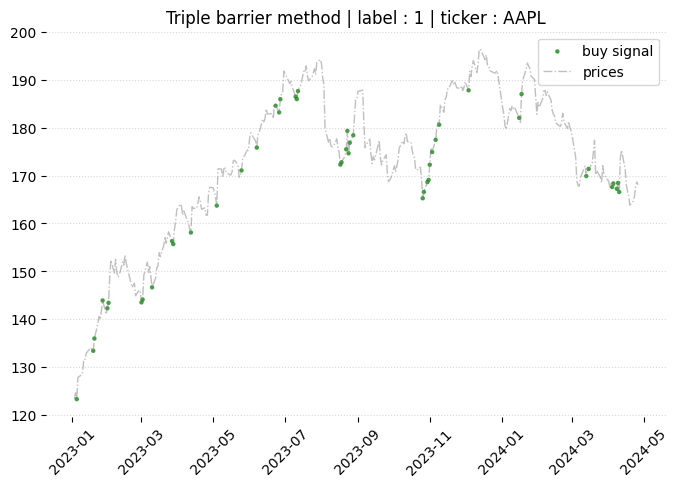

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == 1]['2023':].index,
    data.loc[labels[labels['bin'] == 1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'green',
    label = 'buy signal'
)
ax.plot(
    data['2023':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | label : 1 | ticker : AAPL')
plt.show()

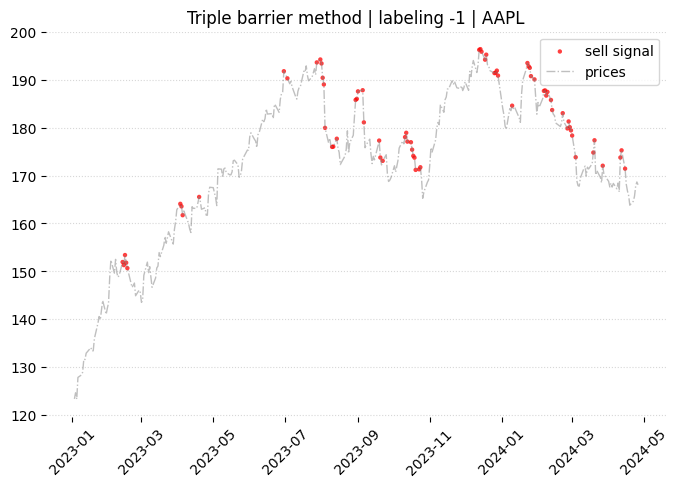

In [26]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == -1]['2023':].index,
    data.loc[labels[labels['bin'] == -1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'red',
    label = 'sell signal'
)
ax.plot(
    data['2023':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | labeling -1 | AAPL')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    labels[labels['bin'] == 1]['2023':].index,
    data.loc[labels[labels['bin'] == 1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'green',
    label = 'buy signal'
)
ax.scatter(
    labels[labels['bin'] == -1]['2023':].index,
    data.loc[labels[labels['bin'] == -1].index]['2023':]['Close'],
    marker = 'o',
    edgecolor = 'none',
    alpha = 0.75,
    s = 10,
    color = 'red',
    label = 'sell signal'
)
ax.plot(
    data['2023':]['Close'],
    alpha = 0.5,
    color = 'gray',
    lw = 1,
    label = 'prices',
    ls = '-.'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title('Triple barrier method | buy sell signal | AAPL')
plt.show()